# Problem Statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, you planned to build a **sentiment-based product recommendation system**, which includes the following tasks.
1. Data sourcing and sentiment analysis
2. Building a recommendation system
3. Improving the recommendations using the sentiment analysis model
4. Deploying the end-to-end project with a user interface

# Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm

nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# import spellchecker
# from spellchecker import SpellChecker

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE

# Import pickle to save and load the model
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances

from numpy import *

# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# importing libraries for XGBoost classifier
import xgboost as xgb
from xgboost import XGBClassifier

from pprint import pprint

In [2]:
# Setting max rows and columns
pd.set_option('max_columns', 50)
pd.set_option('max_rows', 50)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Loading the data

In [4]:
df = pd.read_csv("../input/product-review-dataset/Review Data.csv")

### Exploratory Data Analysis - Data Cleaning and Preprocessing

In [5]:
df.shape

We have 30,000 rows and 15 columns

In [6]:
# Inspect the dataframe to understand the given data.
df.info()

* There are many columns with NULL values. This will need to handled later on.
* We may not require some of the columns as part of our analysis to create Sentiment and Recommender models. We will inspect and remove these later.

In [7]:
# Print top 5 rows of the data
df.head()

Below is the data dictionary that provides information on the type of information contained in each attribute for reference

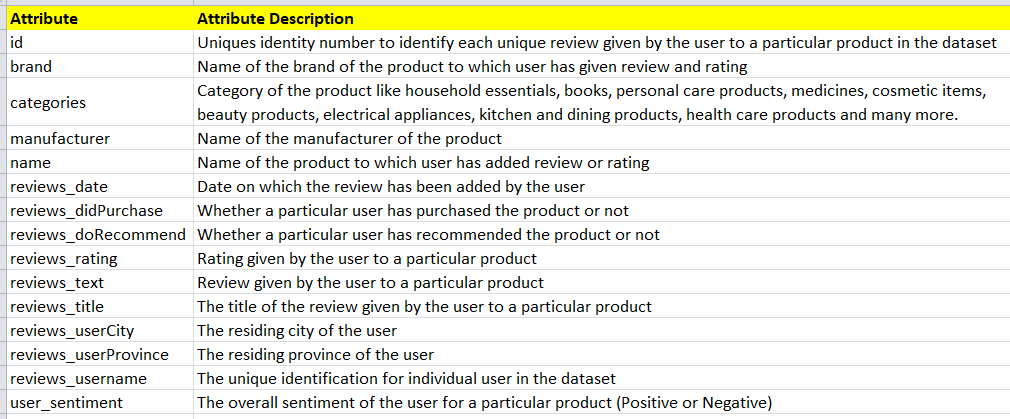]

## Data Cleaning

### Handling NULL values

In [8]:
# Getting total number of NULL values and percentage of the columns
null_count = df[df.columns[df.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df[df.columns[df.isna().any()]].isna().sum() * 100 / df.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

**Observations:**
1. `reviews_userProvince` and `reviews_userCity` have over 93% NULL values and are not useful for analysis. We will remove them from the dataset.
2. `reviews_didPurchase` column has over 46% NULL values. This field is not useful in building either Sentiment/Recommender system as well and will be removed.



### Removing `reviews_userProvince`, `reviews_userCity` and `reviews_didPurchase` from the dataset

In [9]:
df2 = df.copy()

In [10]:
df2.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase'], inplace=True)

In [11]:
df2.shape

In [12]:
# Checking NULLs again
null_count = df2[df2.columns[df2.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df2[df2.columns[df2.isna().any()]].isna().sum() * 100 / df2.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

### Checking `reviews_doRecommend` column


In [13]:
df2.reviews_doRecommend.value_counts(normalize=True)

In [14]:
sns.countplot(x = 'reviews_doRecommend', data = df2)
plt.show()

Looking at the distribution of `reviews_doRecommend` column, we can see that more than 94% of the data is having True value. Hence, the column does not provide any useful information for the model to learn. We will drop this field

In [15]:
df2.drop(columns=['reviews_doRecommend'], inplace=True)

In [16]:
# Checking NULLs again
null_count = df2[df2.columns[df2.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df2[df2.columns[df2.isna().any()]].isna().sum() * 100 / df2.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

### Handling NULL values in `reviews_title`

This column is an important component for our analysis as it contains the title of the review given by the user to a particular product. Since the NULL percentage is only 0.633%, we will remove these rows from the dataset.

In [17]:
# Checking rowcount before deletion
df2.shape

In [18]:
df2 = df2[~ df2.reviews_title.isna() ]

In [19]:
# Checking rowcount post deletion
df2.shape

In [20]:
# Checking NULLs again
null_count = df2[df2.columns[df2.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df2[df2.columns[df2.isna().any()]].isna().sum() * 100 / df2.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

### Handling NULL values in `reviews_username`

This column is an important component for our analysis as it contains the unique identification for individual user in the dataset. Since the NULL percentage is only 0.20%, we will remove these rows from the dataset.

In [21]:
# Checking rowcount before deletion
df2.shape

In [22]:
df2 = df2[~ df2.reviews_username.isna() ]

In [23]:
# Checking rowcount post deletion
df2.shape

In [24]:
# Checking NULLs again
null_count = df2[df2.columns[df2.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df2[df2.columns[df2.isna().any()]].isna().sum() * 100 / df2.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

### Handling NULL values in `user_sentiment`

In [25]:
df2.user_sentiment.value_counts()

In [26]:
df2[ df2.user_sentiment.isna() ]

- As there is only one record with missing data for `user_sentiment`, we will read the record manually and update the value.
- From reading the review title and rating, we can see that the overall sentiment is positive. So, we will update the value as `Positive` for this particular record with NaN.

In [27]:
df2[ df2.user_sentiment.isna() ].user_sentiment

In [28]:
df2.user_sentiment.fillna('Positive', inplace=True)

In [29]:
#map the categorical user_sentiment to numerical 1 or 0 for modelling
df2['user_sentiment'] = df2['user_sentiment'].map({'Positive':1,'Negative':0})

In [30]:
# Checking NULLs again
null_count = df2[df2.columns[df2.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df2[df2.columns[df2.isna().any()]].isna().sum() * 100 / df2.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

As the columns `manufacturer` and `reviews_date` are not needed for both Sentiment and Recommender models we don't need to handle the NULL values for them.

In [31]:
# Check the data for top 5 rows
df2.head()

## Analysis

### Checking Distribution of `reviews_rating` column

In [32]:
sns.countplot(x = 'reviews_rating', data = df2).set(title="Distribution of reviews rating by count", xlabel="reviews rating", ylabel="reviews count")
plt.show()

Most of the ratings from the users have been on the higher side. Most of the review ratings have been 5. This would surely cause a data imbalance as user_sentiment should be in alignment with the ratings. We will check and handle it later on.

### Checking Top 5 Brands with negative reviews

In [33]:
df2[ df2.user_sentiment ==0 ].brand.value_counts(normalize=True, ascending=False).head(5).plot(kind='bar')
plt.title("Top 5 Brands with negative reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage of negative reviews")
plt.show()

`Clorox` is the product that is rated the most negative and nearly 30% of the negative reviews have been towards `Clorox`.

### Checking Top 5 Brands with positive reviews

In [34]:
df2[ df2.user_sentiment == 1 ].brand.value_counts(normalize=True, ascending=False).head(5).plot(kind='bar')
plt.title("Top 5 Brands with positive reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage of positive reviews")
plt.show()

In [35]:
df2.brand.value_counts(normalize=True).head(5)

* Surprisingly `Clorox` is the product that is rated the most positive as well and more than 35% of the positive reviews have been towards `Clorox`.
* Checking the data, we realize that 35% of the brands for which we have the data is actually `Clorox` which is why it has the most reviews.

### Checking review counts based on the review year

In [36]:
# Before type conversion
df2.reviews_date.dtype

- We will first convert `reviews_date` to date type.
- Then we will get the year component from the date.

In [37]:
df2['reviews_date'] = pd.to_datetime(df2['reviews_date'], errors='coerce')

In [38]:
# After type conversion
df2.reviews_date.dtype

In [39]:
# Getting year component from date
df2.reviews_date.dt.year

In [40]:
# Creating a distribution plot based on reviews year 
sns.displot(data=df2, x=df2.reviews_date.dt.year).set(title="Distribution of reviews by year", xlabel="reviews year", ylabel="reviews count")
plt.show()

### Checking Movie categories by Rating

In [41]:
plt.figure(figsize = [10,6])

sns.boxplot(data=df2, x='user_sentiment', y='reviews_rating', color='green')
plt.xticks(rotation = 45)

plt.tight_layout(pad = 4)
plt.show()

In [42]:
df2[ (df2.user_sentiment == 0) & (df2.reviews_rating >= 4) ].groupby(['reviews_rating']).count().user_sentiment

* It's surprising to note that there are brands which have Negative sentiments but much higher review ratings (4 or 5). There are 2396 such records.
* It might be a data anomaly or there might be a data lag between when the rating was provided and user sentiment given later after use.
* For the purpose of this specific business problem, we will treat this specific analysis as out of scope and move further with the pre-processing steps.

## Type Conversion

Before we start the pre-processing steps, we need to make sure that all the text columns are converted to string type for future text operations.

In [43]:
# Convert all the text columns to string for performing text operations
df2['brand'] = df2['brand'].astype(str)
df2['categories'] = df2['categories'].astype(str)
df2['manufacturer'] = df2['manufacturer'].astype(str)
df2['name'] = df2['name'].astype(str)
df2['reviews_text'] = df2['reviews_text'].astype(str)
df2['reviews_title'] = df2['reviews_title'].astype(str)
df2['reviews_username'] = df2['reviews_username'].astype(str)

# Pre-Processing

In [44]:
# Getting a copy of dataframe for pre-processing
df_prep = df2.copy()

## Combining reviews_text and reviews_title columns into reviews_combined and dropping the initial fields

In [45]:
df_prep['reviews_combined'] = df_prep['reviews_text'] + " " + df_prep['reviews_title']
df_prep.drop(columns=['reviews_text', 'reviews_title'], inplace=True)

In [46]:
df_prep.shape

In [47]:
df_prep.head(1)

## Removing columns unneeded for analysis

In [48]:
df_prep.drop(columns=['categories', 'manufacturer', 'reviews_date'], inplace=True)

In [49]:
df_prep.head(1)

## Creating dataframe for Sentiment analysis with only the required columns

In [50]:
df_sent = df_prep[['id','name','reviews_combined', 'user_sentiment']]

In [51]:
df_sent.shape

In [52]:
df_sent.head(2)

## Handling punctuations

In [53]:
# Function to clean the text and remove all the unnecessary elements.
def clean_punctuation(sent):
    sent = sent.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sent = re.sub(pattern, '', sent)
    return sent

In [54]:
df_sent['reviews_cleaned'] = df_sent['reviews_combined'].apply(clean_punctuation)

In [55]:
df_sent.head(2)

## Handling stopwords

In [56]:

stopwords_set = set(stopwords.words("english"))
print(stopwords_set)

In [57]:
# Function to remove the stopwords
def clean_stopwords(sent):
    sent = sent.lower() # Text to lowercase
    words = word_tokenize(sent) # Split sentences into words
    text_nostopwords = " ".join( [each_word for each_word in words if each_word not in stopwords_set] )
    return sent

In [58]:
df_sent['reviews_cleaned'] = df_sent['reviews_cleaned'].apply(clean_stopwords)

In [59]:
df_sent.head(2)

## Handling lemmatization

In [60]:
#Function to lemmatize the text
def clean_lemma(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [61]:
df_sent['reviews_lemmatized'] = df_sent['reviews_cleaned'].apply(clean_lemma)

In [62]:
df_sent.head(2)

In [63]:
df_sent = df_sent[['id','name','reviews_lemmatized', 'user_sentiment']]

In [64]:
df_sent.head(2)

In [65]:
df_sent.shape

In [66]:
# spell = SpellChecker()

In [67]:
# def correct_spelling(text):
#   spell_correctedlist = []
#   words = word_tokenize(text) # Split sentences into words
#   misspelled_words = spell.unknown(words)
#   for each_word in words:
#     # Ignore words which are greater than 13 characters
#     if len(each_word) > 13:
#       continue
#     elif each_word in misspelled_words :
#       # Spell correction 
#       corrected_word = spell.correction(each_word)
#       spell_correctedlist.append(corrected_word)
#     else:
#       # If word is not part of misspelled words, then no alteration is required
#       spell_correctedlist.append(each_word)
#   return " ".join(spell_correctedlist)

In [68]:
# df_sent['reviews_corrected'] = df_sent['reviews_lemmatized'].apply(correct_spelling)

* The spell correction functionality ran for a very long time and did not produce results.
* Even when optimized to correct words less than 13 characters, it is still taking longer.
* For the purpose of this specific assignment, we will ignore the spell correction exercise.

In [69]:
# Visualizing 'reviews_lemmatized' character length
character_length = [len(each_sent) for each_sent in df_sent['reviews_lemmatized']]

sns.displot(character_length, kind='hist', bins=60)
plt.xlabel("Reviews character length")
plt.ylabel("Total number of Reviews")
plt.title("Distribution of Reviews character length")
plt.show()

The distribution is a bit skewed to the right but it is a normal distribution.

In [70]:
#Using a word cloud visualize the top 30 words in review by frequency
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=42, 
                      stopwords=stopwords_wordcloud).generate(str(df_sent['reviews_lemmatized']))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Feature Extraction

In this part, we will be performing
1. Feature Extraction using TF-IDF
2. Check for and handle Class imbalance
3. Perform train, test split

## TF-IDF Feature Extraction

**Feature Extraction using TF-IDF**
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 5 means "ignore terms that appear in less than 5 complaints"

In [71]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [72]:
X = tfidf.fit_transform(df_sent['reviews_lemmatized'])

y= df_sent['user_sentiment']

## Train, test split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [74]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

## Class Imbalance

In [75]:
# Check the data to see if there is a class imbalance in the data
df_sent['user_sentiment'].value_counts(normalize=True)

In [76]:
df_sent.head(2)

From the results above, we can concluded that there is a heavy class imbalance prevalent in the data.
> Positive sentiments make up *89%* of the data and Negative sentiments make up only *11%*

* We are going to handle the imbalance using a technique called SMOTE (Synthetic Minority Oversampling Technique)
* This is an oversampling method that generates synthetic samples for the minority class

In [77]:
counter = Counter(y_train)
print("Before handling imbalance", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After handling imbalance", counter)

Looking at the record count we can see that both Positive and Negative sentiments now have equal number of rows.

# Model Building

We will be creating the following three ML models based on performance for predicting the sentiments based on the text and title of the reviews:
1. Logistic Regression
2. Random Forest
3. XGBoost

In [78]:
# Function to display scores
def evaluation_scores(classifier, X_test, y_test):

  # Calculating Predicted value
  y_pred = classifier.predict(X_test)

  # Create confusion matrix
  conf_m = confusion_matrix(y_test, y_pred)

  print("Visualizing the Confusion Matrix with a Heatmap")
  print("\n")
  print("*"*50)
  # Visualize Confusion Matrix with heatmap
  fig, ax = plt.subplots(figsize=(6, 6))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                  annot=True,
                  cbar=False,
                  cmap="RdYlGn", fmt = '0.1f')
  plt.xlabel("Actual label")
  plt.ylabel("Predicted label")
  plt.show()
  print("*"*50)
  print("\n")

  # Calculating the values of True Positives, True Negatives, False Positivies and False Negatives
  TP = conf_m[1][1]
  TN = conf_m[0][0]
  FP = conf_m[0][1]
  FN = conf_m[1][0]

  print("Values of True Positives, True Negatives, False Positivies and False Negatives")
  print("~"*50)
  print('True Positives:', TP)
  print('True Negatives:', TN)
  print('False Positives:', FP)
  print('False Negatives:', FN)
  print("~"*50)
  print("\n")

  # Calculating Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  accuracy = round(accuracy,2)
  
  # Calculating Sensitivity/Recall
  sensitivity_recall = (TP / float(TP + FN))
  sensitivity_recall = round(sensitivity_recall,2)
  
  # Calculating Specificity
  specificity = (TN / float(TN + FP))
  specificity = round(specificity,2)  
  
  # Calculating Precision
  precision = (TN / float(TN + FP))
  precision = round(precision,2)  
  
  # Calculating F_1 score
  F1_score = 2 * ((precision * sensitivity_recall) / (precision + sensitivity_recall))
  F1_score = round(F1_score,2)  
  
  print("Evaluation Score Summary")
  print('-'*50)
  print(f'Accuracy Score: {round(accuracy,2)}')
  print(f'Sensitivity/Recall Score: {round(sensitivity_recall,2)}') 
  print(f'Specificity Score: {round(specificity,2)}') 
  print(f'Precision: {round(precision,2)}')
  print(f'F1 Score: {round(F1_score,2)}')
  print('-'*50)

  # Returning evaluation results for comparison later
  evaluation_metrics = []
  evaluation_metrics.append(accuracy)
  evaluation_metrics.append(sensitivity_recall)
  evaluation_metrics.append(specificity)
  evaluation_metrics.append(precision)
  evaluation_metrics.append(F1_score)
  
  return evaluation_metrics

## Logistic Regression

### Base Model

In [79]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train_sm, y_train_sm)

In [80]:
# Getting the score of the base model
lr_metrics = evaluation_scores(logreg, X_test, y_test)

In [81]:
# Printing the scores of the base model as reference
df_lrb_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'Logistic Regression Base Model': lr_metrics},
                             columns = ['Metrics', 'Logistic Regression Base Model']
                             )
df_lrb_metrics

### HyperParameter Tuning

In [82]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [83]:
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
logreg_hpt.fit(X_train_sm, y_train_sm);

In [84]:
# Checking the best parameters
logreg_hpt.best_params_

### HyperParameter Tuned Model

In [85]:
# Getting the scores of the tuned model
lr_tuned_metrics = evaluation_scores(logreg_hpt, X_test, y_test)

In [86]:
# Printing the scores of the base and tuned Logistic Regression model for reference
dict_lr_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'LR Base Model': lr_metrics,
                               'LR Tuned Model': lr_tuned_metrics}

df_lr_bt_metrics = pd.DataFrame(dict_lr_bt_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model'])
df_lr_bt_metrics

***Conclusion:***
* For Logistic Regression, Base Model is performing better than the tuned model.
* We will consider the Base Model for evaluation purpose when we are doing model comparison.

## Random Forest Classifier

In [87]:
rf = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)

### Base Model

In [88]:
# Getting the score of the base model
rf_metrics = evaluation_scores(rf, X_test, y_test)

In [89]:
# Printing the scores of the base model as reference
df_rfb_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'RF Base Model': rf_metrics},
                             columns = ['Metrics', 'RF Base Model']
                             )
df_rfb_metrics

Sensitivity and Accuracy are high but Specificity and Precision are low. Let's perform hyperparameter tuning and see if we can improve the scores.

### HyperParameter Tuning

In [90]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}

In [91]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm);

In [92]:
# Check best parameters
rf_hpt.best_params_

In [93]:
evaluation_scores(rf_hpt, X_test, y_test)

Sensitivity, Precision and F1 Score have improved a little bit with Random Search CV. We will strive to improve this further by doing fine hyperparameter tuning using Grid Search CV.

In [94]:
# Fine tuning using Grid Search CV
rf_grid = {"n_estimators": [510],
           "max_depth": [20],
           "min_samples_split": [350, 400],
           "min_samples_leaf": [45, 50]}

In [95]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm);

### HyperParameter tuned model

In [96]:
# Getting the scores of the tuned model
rf_tuned_metrics = evaluation_scores(rf_hpt, X_test, y_test)

In [97]:
# Printing the scores of the base and tuned Random Forest model as reference
dict_rf_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'RF Base Model': rf_metrics,
                               'RF Tuned Model': rf_tuned_metrics}

df_rf_bt_metrics = pd.DataFrame(dict_rf_bt_metrics, columns = ['Metrics', 'RF Base Model', 'RF Tuned Model'])
df_rf_bt_metrics

**Conclusion:**

For Random Forest, Tuned Model is performing better than the base model as F1 Score is better.
We will consider the Tuned Model for evaluation purpose when we are doing model comparison.

## XGBoost Classifier

In [98]:
xg = xgb.XGBClassifier(random_state=42).fit(X_train_sm, y_train_sm)

### Base Model

In [99]:
# Getting the score of the base model
xg_metrics = evaluation_scores(xg, X_test, y_test)

In [100]:
# Printing the scores of the base model as reference
df_xgb_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'XG Base Model': xg_metrics},
                             columns = ['Metrics', 'XG Base Model']
                             )
df_xgb_metrics

### HyperParameter Tuning

In [101]:
xg_grid = {"learning_rate": np.arange(0.05, 1, 0.1),
           "max_depth": np.arange(5, 20, 5)
           }

In [102]:
# Setup random hyperparameter search for Random Forest Classifier
xg_hpt = RandomizedSearchCV(XGBClassifier(random_state=42),
                                param_distributions=xg_grid,
                                cv=4,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_train_sm);

In [103]:
# Check best parameters
xg_hpt.best_params_

In [104]:
evaluation_scores(xg_hpt, X_test, y_test)

We will perform further fine tuning with Grid Search CV

In [105]:
# Fine tuning with Grid Search CV
xg_grid = {"learning_rate": [0.45, 0.15],
           "max_depth": [5, 10]
           }

In [106]:
# Setup random hyperparameter search for Random Forest Classifier
xg_hpt = GridSearchCV(XGBClassifier(random_state=42),
                                param_grid=xg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_train_sm);

In [107]:
# Check best parameters
xg_hpt.best_params_

### HyperParameter tuned model

In [108]:
# Getting the scores of the tuned model
xg_tuned_metrics = evaluation_scores(xg_hpt, X_test, y_test)

In [109]:
# Printing the scores of the base and tuned XGBoost model as reference
dict_xg_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'XG Base Model': xg_metrics,
                               'XG Tuned Model': xg_tuned_metrics}

df_xg_bt_metrics = pd.DataFrame(dict_xg_bt_metrics, columns = ['Metrics', 'XG Base Model', 'XG Tuned Model'])
df_xg_bt_metrics

***Conclusion:***
* For XG Boost model, Base Model is performing better than the tuned model.
* We will consider the Base Model for evaluation purpose when we are doing model comparison.

# Model Evaluation

In [110]:
# Printing the scores of all the 3 Models (Base and Tuned)
dict_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'],
                              'LR Base Model': lr_metrics, 'LR Tuned Model': lr_tuned_metrics,
                              'RF Base Model': rf_metrics, 'RF Tuned Model': rf_tuned_metrics,}
                              #'XG Base Model': xg_metrics, 'XG Tuned Model': xg_tuned_metrics}

#df_bt_metrics = pd.DataFrame(dict_bt_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model', 'RF Base Model', 'RF Tuned Model', 'XG Base Model', 'XG Tuned Model'])
df_bt_metrics = pd.DataFrame(dict_bt_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model', 'RF Base Model', 'RF Tuned Model'])
df_bt_metrics

Looking at the model evaluation metrics and focusing on Sensitivity, Specificity and F1 Score, we can conclude that the base Logistic Regression Model is the best model out of all of them.

# Building a Recommendation System

We will build the below two recommendation systems
1. User-based recommendation system
2. Item-based recommendation system

Once built, we will analyze the recommendation systems and select the one that is best suited in this case. 
Once we get the best-suited recommendation system, the next task will be to recommend 20 products that a user is most likely to purchase based on the ratings.

## Import data

In [111]:
df_reco = pd.read_csv("../input/product-review-dataset/Review Data.csv")

In [112]:
df_reco.shape

In [113]:
# We need only the below columns for building a recommendation system
df_reco = df_reco[["id", "name", "reviews_rating", "reviews_username"]]

In [114]:
df_reco.shape

In [115]:
df_reco.head(2)

## Handling NULL values

In [116]:
# Getting total number of NULL values and percentage of the columns
null_count = df_reco[df_reco.columns[df_reco.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_reco[df_reco.columns[df_reco.isna().any()]].isna().sum() * 100 / df_reco.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

In [117]:
# Removing the rows where reviews_username is NULL
df_reco = df_reco[~ df_reco.reviews_username.isna() ]

In [118]:
df_reco.shape

In [119]:
# Check if any NULL values still exist in the dataset
null_count = df_reco[df_reco.columns[df_reco.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_reco[df_reco.columns[df_reco.isna().any()]].isna().sum() * 100 / df_reco.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

## Train, Test Split

In [120]:
train, test = train_test_split(df_reco, test_size=0.30, random_state=42)

In [121]:
print(train.shape)
print(test.shape)

In [122]:
train.head(2)

In [123]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

## Creating dummy train & dummy test dataset

- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 
- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [124]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [125]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [126]:
# Convert the dummy train dataset into matrix format
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

dummy_train.head(3)

In [127]:
dummy_train.head(2)

**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is `reviews_rating` in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.



## User Similarity Matrix (Using Adjusted Cosine)

### Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

In [128]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

In [129]:
# For verification purpose, we do have cases where the rating is not NaN
df_pivot[~df_pivot['AV13O1A8GV-KLJ3akUyj'].isna()]

### Normalising the rating of the product for each user around 0 mean

In [130]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [131]:
df_subtracted.head()

### Finding cosine similarity

In [132]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

In [133]:
user_correlation.shape

## Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, we will be ignoring the correlation for values less than 0.

In [134]:
user_correlation[user_correlation<0]=0
user_correlation

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [135]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

In [136]:
user_predicted_ratings.shape

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.

In [137]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

## Finding the Top 20 products that a user is most likely to purchase based on the ratings (user-user based recommendation)

In [138]:
# Take a sample username as input.
user_input = '00sab00'

In [139]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

In [140]:
top20_rec = pd.merge(df_reco, df_top20_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

## Evaluation - User User

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [141]:
train.head(2)

In [142]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

In [143]:
common.head(2)

In [144]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [145]:
common_user_based_matrix.head(2)

In [146]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [147]:
user_correlation_df.head(2)

In [148]:
df_subtracted.head(1)

In [149]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head(2)

In [150]:
common.head(1)

In [151]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [152]:
user_correlation_df_1.shape

In [153]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [154]:
user_correlation_df_3 = user_correlation_df_2.T

In [155]:
user_correlation_df_3.head()

In [156]:
user_correlation_df_3.shape

In [157]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

In [158]:
common.head(2)

In [159]:
# Creating dummy test dataframe
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [160]:
dummy_test.shape

In [161]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [162]:
common_user_predicted_ratings.head(2)

* Calculating the RMSE for only the products rated by user.
* For RMSE, normalising the rating to (1,5) range.

In [163]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [164]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [165]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

RMSE (Root Mean Square Error) for User-User recommendation system

In [166]:
rmse_user_user = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_user_user)

## Using Item Similarity

### Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different Product ID. In the user based similarity, we had taken mean for each user instead of each product. 

In [167]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

In [168]:
df_pivot.head()

Normalizing the product rating for each product for using the Adujsted Cosine

In [169]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [170]:
df_subtracted.head()

Finding the cosine similarity using pairwise distances approach

In [171]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [172]:
item_correlation[item_correlation<0]=0
item_correlation

## Prediction - Item Item

In [173]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

In [174]:
item_predicted_ratings.shape

In [175]:
dummy_train.shape

### Filtering the rating only for the products not rated by the user for recommendation

In [176]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

In [177]:
# Take a sample username as input.
user_input = '00sab00'

In [178]:
item_final_rating.head(2)

In [179]:
top20_item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_item_recommendations = pd.DataFrame({'Product Id': top20_item_recommendations.index, 'cosine_similarity_score' : top20_item_recommendations})
df_top20_item_recommendations.reset_index(drop=True, inplace=True)
df_top20_item_recommendations

## Finding the Top 20 products that a user is most likely to purchase based on the ratings (item-item based recommendation)

In [180]:
top20_item_rec = pd.merge(df_reco, df_top20_item_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_item_rec.reset_index(drop=True, inplace=True)
top20_item_rec.sort_values(by='cosine_similarity_score', ascending=False)

## Evaluation - Item Item

Evaluation will we same as we have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [181]:
test.columns

In [182]:
# Find out the common products of test and train dataset.
common = test[test.id.isin(train.id)]
common.shape

In [183]:
common.head(2)

In [184]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [185]:
common_item_based_matrix.shape

In [186]:
item_correlation_df = pd.DataFrame(item_correlation)

In [187]:
item_correlation_df.head(2)

In [188]:
item_correlation_df['movieId'] = df_subtracted.index
item_correlation_df.set_index('movieId',inplace=True)
item_correlation_df.head()

In [189]:
list_name = common.id.tolist()

In [190]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [191]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [192]:
item_correlation_df_3.head(2)

In [193]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

In [194]:
common_item_predicted_ratings.shape

In [195]:
common.head(2)

In [196]:
# Dummy test will be used for evaluation
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated are marked as 0 for evaluation

In [197]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [198]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [199]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

RMSE (Root Mean Square Error) for Item-Item recommendation system

In [200]:
rmse_item_item = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

# Best-suited Recommendation model

* To get the best recommendation model, we will use RMSE (Root Mean Square Error) scores for both user-user and item-item based recommendation systems and do a comparison of the values.
* The recommendation model with the least RMSE will be selected as the best recommendation model.

In [201]:
# Recommended model evaluation
if rmse_user_user < rmse_item_item:
  print("Best-fit model is user-user recommendation system")
else:
  print("Best-fit model is item-item recommendation system")

# Top 20 Product recommendations to the user by the best recommendation model (user-user based recommendation system)

In [202]:
# Take a sample username as input
user_input = 'evrydayhustla420'

In [203]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

In [204]:
top20_rec = pd.merge(df_reco, df_top20_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

In [205]:
user_final_rating.shape

In [206]:
user_final_rating.head(2)

# Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

In [207]:
# Create function to recommend top 5 products to any user
def product_recommendations_user(user_name):
  if user_name not in user_final_rating.index:
    print(f"The User {user_name} does not exist. Please provide a valid user name")
  else:
    # Get top 20 recommended products from the best recommendation model
    top20_recommended_products = list(user_final_rating.loc[user_name].sort_values(ascending=False)[0:20].index)
    # Get only the recommended products from the prepared dataframe "df_sent"
    df_top20_products = df_sent[df_sent.id.isin(top20_recommended_products)]
    # For these 20 products, get their user reviews and pass them through TF-IDF vectorizer to convert the data into suitable format for modeling
    X = tfidf.transform(df_top20_products["reviews_lemmatized"].values.astype(str))
    # Use the best sentiment model to predict the sentiment for these user reviews
    df_top20_products['predicted_sentiment'] = logreg.predict(X)
    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    pred_df = df_top20_products.groupby(by='name').sum()
    pred_df.columns=['name', 'pos_sent_count']
    # Create a column to measure the total sentiment count
    pred_df['total_sent_count'] = df_top20_products.groupby(by='name')['predicted_sentiment'].count()
    # Create a column that measures the % of positive user sentiment for each product review
    pred_df['post_sent_percentage'] = np.round(pred_df['pos_sent_count']/pred_df['total_sent_count']*100,2)
    # Return top 5 recommended products to the user
    return pred_df.sort_values(by='post_sent_percentage', ascending=False)[:5]    

# Top 5 Products Recommendation

In [208]:
# Take a sample username as input
user_input = 'charlie'
# 'Venkat'
# 'debb'
# 'evrydayhustla420'
print(f"Printing the top 5 recommended products for the user: {user_input} along with each product's positive sentiment count, overall review count and positive sentiment %")
print("\n")
top5_reco_sent_reco_user = product_recommendations_user(user_input)
top5_reco_sent_reco_user

In [209]:
# Showing only the top 5 Product Names for the user
print(f"Printing the top 5 recommended products list for the user: {user_input}")
print(list(top5_reco_sent_reco_user.index))